## Exploring experiments

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

from os import path
import logging
import dill
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from trojan_defender import (experiment, set_root_folder,
                             datasets, set_db_conf, plot,
                             get_db_conf)
from trojan_defender.detect import saliency_ as saliency
from trojan_defender import datasets
from pymongo import MongoClient

/home/Edu/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/Edu/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# config logging
logging.basicConfig(level=logging.ERROR)

# matplotlib size
plt.rcParams['figure.figsize'] = (10, 10)

# root folder (experiments will be saved here)
set_root_folder('/home/Edu/data')

dump_folder = '/home/Edu/saliency'

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

In [3]:
clean = datasets.mnist()

def detect(directory):
    model, dataset, metadata = experiment.load(directory)

    try:
        res = saliency.detect(model, clean, random_trials=100)
        (sms_model, outs, recovered, sample, test, flips,
            mode_changes, mask_prop) = res
    except ValueError as e:
        print('error', e)
    else:
        print(flips, mode_changes)
    
    return res

In [4]:
def detection_round(model, dump=False):
    directory = model['directory']
    metrics = model['metrics']
    acc = metrics['accuracy_score']
    success = metrics.get('patch_success_rate') if metrics.get('patch_success_rate') else 0.0
    print(directory)
    print('{:.2f}\t{:.2f}'.format(acc, success))
    (sms_model, outs, recovered, sample, test, flips,
            mode_changes, mask_prop) = detect(directory)
    print('\n\n')
    
    with open(path.join(dump_folder, directory+'.pickle'), 'wb') as f:
        res = (acc, success, sms_model, outs, recovered,
               sample, test, flips,
               mode_changes, mask_prop)
        dill.dump(res, f)

    return acc, success, flips, mode_changes

In [5]:
def get_dump(directory):
    with open(path.join(dump_folder, directory+'.pickle'), 'rb') as f:
        res = dill.load(f)

    return res

In [6]:
conf = get_db_conf()
client = MongoClient(conf['uri'])
con = client[conf['db']][conf['collection']]

In [ ]:
group = con.find({'dataset.name': 'MNIST',
                  'group_name': 'big_mnist'})

In [ ]:
res = [detection_round(model) for model in group]

In [7]:
noisy = con.find({'dataset.name': 'MNIST',
                  'metrics.patch_success_rate': {"$lt": 0.05},
                  'group_name': 'big_mnist',})

In [8]:
res = [detection_round(model) for model in noisy]

27-Apr-2018@05-28-30
0.99	0.00
(0.020000000000000004, 0.04) 0.0



27-Apr-2018@05-29-31
0.98	0.01
(0.0, 0.0) 0.0



27-Apr-2018@05-30-27
0.98	0.02
(0.172, 0.07082372483850309) 0.1



27-Apr-2018@05-40-55
0.98	0.03
(0.7010000000000001, 0.13152566289511716) 0.7



27-Apr-2018@06-37-30
0.96	0.03
(0.9000000000000005, 4.440892098500626e-16) 0.9



27-Apr-2018@06-38-34
0.96	0.03
(0.8380000000000001, 0.05055689863905814) 0.8



27-Apr-2018@06-39-38
0.96	0.03
(0.8990000000000004, 0.009949874371066196) 0.9





In [ ]:
# get mnist experiments with high success rate
# run detector
# compute performance
mnist = con.find({'dataset.name': 'MNIST',
                  'metrics.patch_success_rate': {"$gt": 0.90}})

In [ ]:
# get mnist experiments with low success rate
# run detector
# compute performance
baselines = con.find({'dataset.name': 'MNIST',
                      'metrics.patch_success_rate': {"$exists": False}})

## Plots

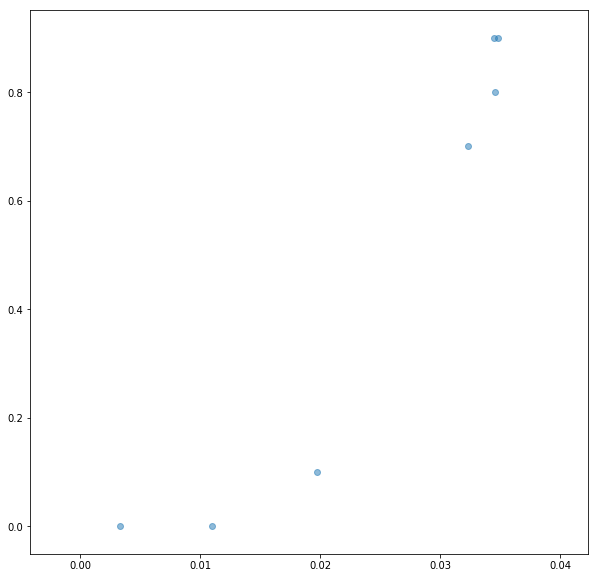

In [9]:
success = [r[1] for r in res]
mode_changes = [r[3] for r in res]

plt.scatter(success, mode_changes, alpha=0.5)